# NER for Extracting Stock Mentions on Reddit

## Sentiment Analysis

This project is copied and editted from the following project:

https://towardsdatascience.com/ner-for-extracting-stock-mentions-on-reddit-aa604e577be

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import flair
import ast
from pprint import pprint
import matplotlib.pyplot as plt

tqdm.pandas()

# Import Sentiment model

In [2]:
model = flair.models.TextClassifier.load('en-sentiment')

2022-09-19 10:11:14,085 loading file C:\Users\WeiYanPEH\.flair\models\sentiment-en-mix-distillbert_4.pt


# Define function to extract Sentiments

In [3]:
def get_sentiment(text):
    # tokenize input text
    sentence = flair.data.Sentence(text)
    # make sentiment prediction
    model.predict(sentence)
    # extract sentiment direction and confidence (label and score) object
    sentiment = sentence.labels[0]
    return sentiment

# Load NER data to perform Sentiments

In [4]:
# load data
df = pd.read_csv('./data/processed/reddit_all_ner.csv', sep='|')
print(df.shape)

(6197, 15)


# Extract Sentiments, and save them
This step takes extremely long to run

In [5]:
# get sentiment
#df['sentiment'] = df['selftext'].progress_apply(get_sentiment)
#print(df.shape)
#df.to_csv('./data/processed/reddit_all_ner_sentiments.csv')

100%|██████████| 6197/6197 [25:47<00:00,  4.01it/s] 

(6197, 16)


In [24]:
df = pd.read_csv('./data/processed/reddit_all_ner.csv', sep='|')

In [6]:
label_list = [
              #'CARDINAL', 
              #'DATE', 
              #'EVENT', 
              #'FAC', 
              'GPE', 
              #'LANGUAGE', 
              #'LAW', 
              'LOC', 
              #'MONEY', 
              'NORP', 
              #'ORDINAL', 
              'ORG', 
              #'PERCENT', 
              'PERSON', 
              'PRODUCT', 
              #'QUANTITY', 
              #'TIME', 
              #'WORK_OF_ART',
             ]

In [7]:
for label in label_list:
    df[label] = df[label].progress_apply(lambda x: ast.literal_eval(x))

100%|██████████| 6197/6197 [00:00<00:00, 95659.43it/s]


# Create nested dictionaries to store the sentiments of entity group + entity

In [8]:
# initialize sentiment dictionary
sentiment = {}

for label in label_list:
    sentiment[label] = {}

# loop through dataframe and extract org labels and sentiment scores into sentiment dictionary
for i, row in df.iterrows():
    # extract sentiment direction and score
    direction = row['sentiment'].value
    score = row['sentiment'].score
    # loop through each label in organizations column
    for label in label_list:
        for org in row[label]:
            # check if org label exists in sentiment dictionary already
            if org not in sentiment[label].keys():
                # if it doesn't, initialize new entry in dictionary
                sentiment[label][org] = {'POSITIVE': [], 'NEGATIVE': []}
            # append positive/negative score to respective dictionary entry
            sentiment[label][org][direction].append(score)

In [9]:
sentiment['ORG']['ARK']

{'POSITIVE': [0.6441313028335571], 'NEGATIVE': [0.829578697681427]}

In [10]:
#sentiment['ORG']['AMC']

In [11]:
#sentiment['ORG']['Tesla']

# We remove any entity with too few (<2) sentiments assigned to it

In [12]:
sentiment_new = {}

for label in label_list:
    sentiment_new[label] = {}
    
for label in label_list:
    for key in sentiment[label].keys():
        temp = sentiment[label][key]

        if len(temp['POSITIVE']) + len(temp['NEGATIVE'])>2:
            sentiment_new[label][key] = sentiment[label][key]

In [13]:
sentiment_new.keys()

dict_keys(['GPE', 'LOC', 'NORP', 'ORG', 'PERSON', 'PRODUCT'])

In [14]:
for label in label_list:
    pprint(list(sentiment_new[label].keys())[:5])

['ERC20', 'US', 'Norway', 'Shanghai', 'London']
['North America', 'Europe', 'Latin America', 'the Middle East', 'Africa']
['Japanese', 'North Korean', 'Argentinian', 'Americans', 'Spanish']
['ENS', 'Ethereum', 'ETH', 'NASDAQ', 'Merge']
['Joe', 'Michael Saylor', 'Axie Infinity', 'GameFi', 'Monero']
['MetaMask', 'Twitter', 'Coinbase', 'Metis', 'Merge']


# Now, all the entities has at least 2 sentiments assigned to them

In [15]:
for label in label_list:
    print('\n########## ' + label + ' ##########')
    for key in list(sentiment_new[label].keys())[:10]:
        if (len(sentiment_new[label][key]['POSITIVE']) + len(sentiment_new[label][key]['NEGATIVE'])) < 5:
            print(key, sentiment_new[label][key])


########## GPE ##########
ERC20 {'POSITIVE': [0.8843597769737244], 'NEGATIVE': [0.9834363460540771, 0.9999165534973145]}
Norway {'POSITIVE': [0.9979811310768127, 0.9906777143478394], 'NEGATIVE': [0.9855107069015503]}
DeFi {'POSITIVE': [0.8733268976211548, 0.9983347058296204], 'NEGATIVE': [0.666695773601532, 0.9797787666320801]}
Lido {'POSITIVE': [], 'NEGATIVE': [0.9863348007202148, 0.9981712102890015, 0.9998668432235718]}

########## LOC ##########
the Middle East {'POSITIVE': [0.735891580581665, 0.9985452890396118], 'NEGATIVE': [0.9839343428611755, 0.9993708729743958]}
Euro {'POSITIVE': [], 'NEGATIVE': [0.9997552037239075, 0.9999831914901733, 0.8026689291000366]}
Evergrande {'POSITIVE': [0.9688194990158081], 'NEGATIVE': [0.9999611377716064, 0.9999054670333862]}

########## NORP ##########
North Korean {'POSITIVE': [], 'NEGATIVE': [0.9998021721839905, 0.666695773601532, 0.9988579750061035]}
Argentinian {'POSITIVE': [], 'NEGATIVE': [0.8213438987731934, 0.9625318050384521, 0.98464059829

# Now, we want to get the average positive and negative scores for each entity. Additionally, we want to get the overall score of any entity

In [16]:
# initialize sentiment list
avg_sentiment = {}

for label in label_list:
    avg_sentiment[label] = []

# loop through each organization
sentiment_temp = sentiment.copy()

for label in label_list:
    for org in sentiment_temp[label].keys():
        # get number of positive and negative ratings
        freq = len(sentiment_temp[label][org]['POSITIVE']) + len(sentiment_temp[label][org]['NEGATIVE'])
        for direction in ['POSITIVE', 'NEGATIVE']:
            # assign to variable for cleaner code
            score = sentiment_temp[label][org][direction]
            # if there are no entries, set to 0
            if len(score) == 0:
                sentiment_temp[label][org][direction] = 0.0
            else:
                # otherwise calculate total
                sentiment_temp[label][org][direction] = sum(score)
        # now calculate total amount
        total = sentiment_temp[label][org]['POSITIVE'] - sentiment_temp[label][org]['NEGATIVE']
        # and the average score
        avg = total/freq
        # add to sentiment list
        avg_sentiment[label].append({
            'entity': org,
            'positive': sentiment_temp[label][org]['POSITIVE'],
            'negative': sentiment_temp[label][org]['NEGATIVE'],
            'frequency': freq,
            'score': avg
        })

In [29]:
avg_sentiment['GPE'][0]

{'entity': 'ERC20',
 'positive': 0.8843597769737244,
 'negative': 1.9833528995513916,
 'frequency': 3,
 'score': -0.3663310408592224}

In [18]:
df_sentiment = pd.DataFrame()

for label in label_list:
    df_sentiment_temp = pd.DataFrame(avg_sentiment[label])
    df_sentiment_temp['Label'] = label
    df_sentiment = pd.concat([df_sentiment, df_sentiment_temp], axis=0)
    
df_sentiment.to_csv('./data/processed/reddit_all_sentiment.csv', sep='|', index=False)

In [19]:
df_sentiment.head(5)

,entity,positive,negative,frequency,score,Label
0,ERC20,0.884360,1.983353,3,-0.366331,GPE
1,US,79.085721,227.506515,328,-0.452502,GPE
2,RUSSELL,0.000000,0.980817,1,-0.980817,GPE
3,Norway,1.988659,0.985511,3,0.334383,GPE
4,Shanghai,0.998481,4.966918,6,-0.661406,GPE


# We plot the bar plot of the top few entities with the highest/lowest sentiment scores

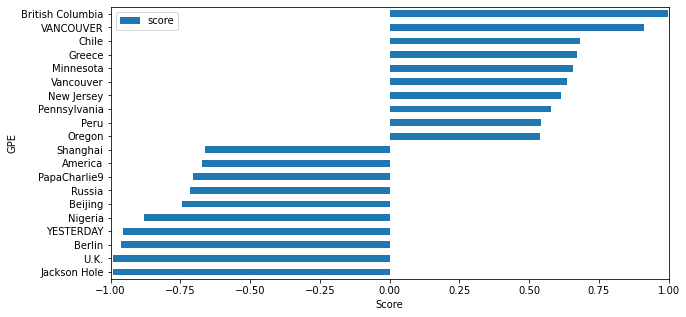

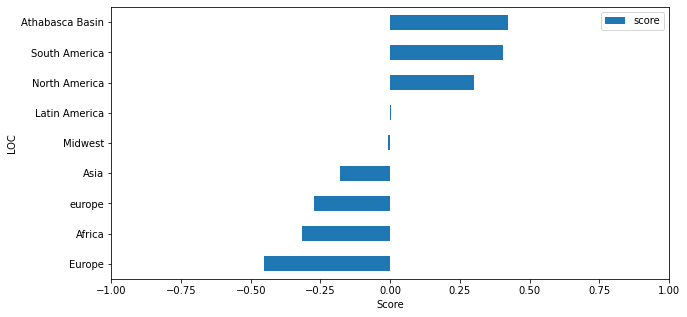

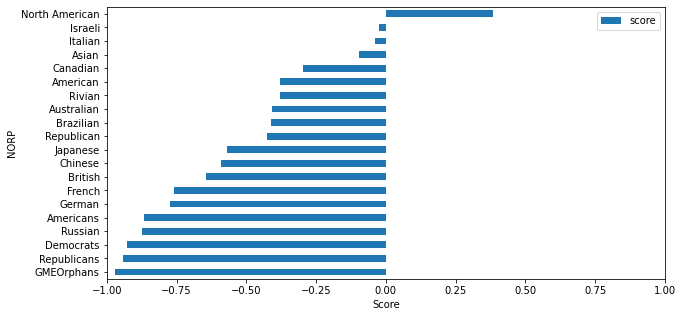

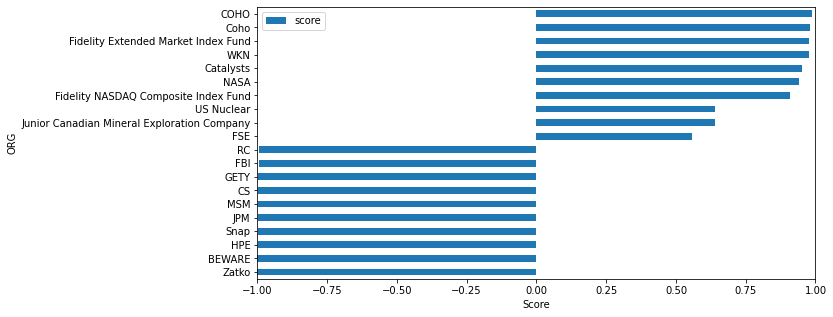

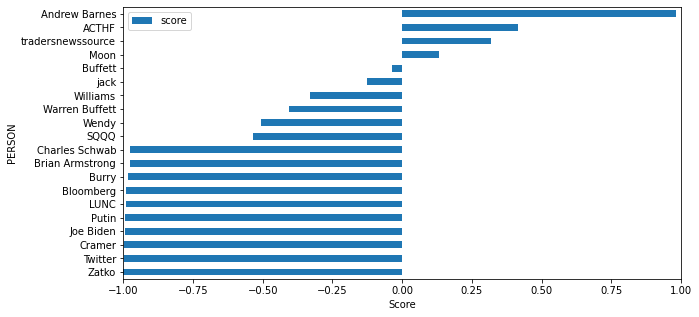

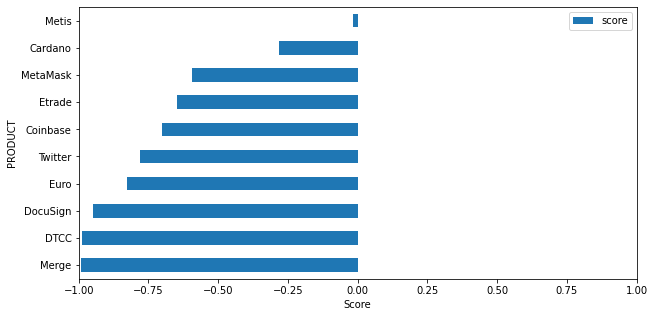

In [25]:
for label in label_list:
    df_sentiment = df_sentiment[df_sentiment['frequency'] > 5].reset_index(drop=True)
    df_sentiment = df_sentiment.sort_values('score', ascending=True).reset_index(drop=True)

    df_temp = df_sentiment[df_sentiment['Label']==label].reset_index(drop=True)   
    
    if len(df_temp)>20:
        head_tail_slice = list(range(10))+list(range(-10,0))
        df_temp = df_temp.iloc[head_tail_slice]
        
    df_temp = df_temp.drop_duplicates()
    
    df_temp.plot.barh(x='entity', y='score', figsize=(10,5))            
    plt.xlabel('Score')
    plt.ylabel(label)
    plt.xlim([-1,1])